# Integrate workout clusters in biometrics states

In [199]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

Now contains at least one occurence of obese cluster, top 5 states with the largest difference in biometrics and males

#### Keep biometrics columns

In [200]:
# biometric_columns = ['BMI', 'Basal Metabolic Rate', 'Bone Mass', 'Degree Of Obesity Perc',
#                    'Extra Cellular Water Perc', 'Fat Free Mass', 'Fat mass Perc', 'Height', 
#                    'Intra Cellular Water', 'Left Arm Fat Perc', 'Left Leg Fat Perc', 'Metabolic Age', 
#                    'Muscle Mass', 'Muscle Mass Balance Arm', 'Muscle Mass Balance Leg', 
#                    'Right Arm Fat Perc', 'Right Leg Fat Perc', 'Standard Body Weight', 
#                    'Total Body Water Perc', 'Trunk Fat Perc', 'Trunk Muscle Mass', 
#                    'Visceral Fat Rating', 'Weight']

biometric_columns  = [
    'BMI', 'Degree Of Obesity Perc', 'Fat mass Perc', 'Intra Cellular Water',
    'Left Arm Fat Perc', 'Left Leg Fat Perc', 'Right Arm Fat Perc', 'Right Leg Fat Perc',
    'Standard Body Weight', 'Total Body Water Perc', 'Trunk Fat Perc', 'Visceral Fat Rating',
    'Weight_per_height', 'Muscle Mass_per_height', 'Fat Free Mass_per_height',
    'Bone Mass_per_height', 'Trunk Muscle Mass_per_height',
    'Basal Metabolic Rate_per_age', 'Metabolic Age_per_age'
]

In [201]:
# bio = pd.read_pickle(('../data_cleaned/biometrics_m10_imputed_clustered_changes_reduced.pkl'))
# bio = pd.read_pickle('../data_processed/biometrics_m10_imputed_clustered_changes.pkl')
bio = pd.read_pickle('../data_processed/biometrics_clustered_males.pkl')

In [202]:
# read exercise data
exercises = pd.read_pickle('../data_processed/workouts_clustered.pkl')
exercises = exercises[exercises['CloudId'].isin(bio['CloudId'])]
exercises['DoneOnWeek'] = pd.to_datetime(exercises['Date']).dt.isocalendar().week
print(exercises.shape)
exercises.head(2)

(69040, 31)


,total_workout_duration,total_calories_burnt,total_cardio_calories,total_cardio_duration,total_isotonic_calories,total_isotonic_duration,duration_core,duration_lower_body,duration_total_body,duration_upper_body,duration_cardiovascular,duration_flexibility_mobility,duration_free_weights,duration_functional_training,duration_strength_training,Intensity,total_cardio_duration_ratio,total_isotonic_duration_ratio,duration_core_ratio,duration_lower_body_ratio,duration_total_body_ratio,duration_upper_body_ratio,duration_cardiovascular_ratio,duration_flexibility_mobility_ratio,duration_free_weights_ratio,duration_functional_training_ratio,duration_strength_training_ratio,Cluster,CloudId,Date,DoneOnWeek
195,18.0,332.0,332.0,18.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0,0.0,0.0,0.0,0.0,0.307407,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0022b439d0d622b758a0e9d0a8c8ea47c9d4f871,2022-09-11,36
196,23.0,428.0,428.0,23.0,0.0,0.0,0.0,0.0,23.0,0.0,23.0,0.0,0.0,0.0,0.0,0.310145,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0022b439d0d622b758a0e9d0a8c8ea47c9d4f871,2022-09-13,37


### Merge biometrics cluster with exercise cluster

I have two dataframes: biometrcis and exercises. For both of them we have a cluster and the week on which we were done. We will make the following two dataframes:

1) A dataframe with biometrcis states for which we will keep 4 states of users. We will keep the states for which we have an exercise cluster change in between and if more than 4 states that meet this requirement exist, we will keep the states for which we had a bigger change in biometrics (in total)
2) A new dataframe which records are a timepoint in between the biometrics states and it denotes a change in exercise cluster. It will contain the cloudid of the user, the week in which we had the change and an array with the change of cluster (if the user has gone from cluster 1 to cluster 2 we will have [1,2])

In [203]:
# keep only Cluster, DoneOnWeek, CloudId with loc
exercises = exercises.loc[:, ['Cluster', 'DoneOnWeek', 'CloudId']]
exercises.head(2)

,Cluster,DoneOnWeek,CloudId
195,2,36,0022b439d0d622b758a0e9d0a8c8ea47c9d4f871
196,2,37,0022b439d0d622b758a0e9d0a8c8ea47c9d4f871


#### For multiple years we also need to keep the year

## Add workout in trajectories 

Make a new dataframe which will represent transitions

In [204]:
bio['stateid'] = range(len(bio))

## Keep only individuals with one occurence of obesity

In [205]:
obese_starting = bio[bio['Cluster'] == 2]['CloudId'].values
bio = bio[bio['CloudId'].isin(obese_starting)]
bio.head()

,BMI,Degree Of Obesity Perc,Fat mass Perc,Intra Cellular Water,Left Arm Fat Perc,Left Leg Fat Perc,Right Arm Fat Perc,Right Leg Fat Perc,Standard Body Weight,Total Body Water Perc,Trunk Fat Perc,Visceral Fat Rating,Weight_per_height,Muscle Mass_per_height,Fat Free Mass_per_height,Bone Mass_per_height,Trunk Muscle Mass_per_height,Basal Metabolic Rate_per_age,Metabolic Age_per_age,Cluster,CloudId,MeasuredOnWeek,PCA1,PCA2,stateid
105,24.6,11.7,18.2,29.3,15.7,14.7,15.1,11.9,73.7,58.7,21.8,3.0,0.449727,0.349727,0.367760,0.018033,0.183607,95.952381,1.047619,1,006f1c008857f4345ce467a6d17f43362e512908,2,-1.142097,2.094219,27
106,24.6,11.9,19.3,28.7,17.1,15.2,16.5,12.9,73.7,57.7,23.0,3.0,0.450820,0.345902,0.363934,0.018033,0.180874,95.142857,1.190476,1,006f1c008857f4345ce467a6d17f43362e512908,3,-0.692754,1.749934,28
107,24.6,11.9,18.2,29.3,16.0,14.4,15.6,11.6,73.7,58.7,21.8,3.0,0.450820,0.350820,0.368852,0.018033,0.183607,96.238095,1.047619,1,006f1c008857f4345ce467a6d17f43362e512908,4,-1.118118,2.119899,29
108,24.5,11.3,18.8,28.7,16.6,15.3,15.9,12.7,73.7,57.9,22.0,3.0,0.448087,0.345902,0.363934,0.018033,0.181967,94.761905,1.142857,1,006f1c008857f4345ce467a6d17f43362e512908,5,-0.892651,1.806680,30
109,24.3,10.6,19.2,28.2,17.1,15.3,16.5,12.7,73.7,57.5,22.6,3.0,0.445355,0.342077,0.360109,0.018033,0.179781,93.809524,1.190476,1,006f1c008857f4345ce467a6d17f43362e512908,8,-0.817138,1.582188,31


## Keep only top X states with highest difference in biometrics

In [206]:
TOPXNUMBERS = 6

def select_top_states(group):
    # Ensure chronological order
    group = group.sort_values(by='MeasuredOnWeek').reset_index(drop=True)
    
    # Calculate absolute differences between consecutive measurements for each column
    diff_cols = [col for col in group.columns if col not in ['gender_m', 'gender_f', 'CloudId', 'MeasuredOnWeek', 'Cluster', 'Age']]
    group['Diff'] = group[diff_cols].diff().abs().sum(axis=1)
    
    # Always include the first measurement
    indices = [0]
    
    # Select the top 3 measurements with the largest changes
    if len(group) > 1:
        largest_changes = group.iloc[1:].nlargest(TOPXNUMBERS - 1, 'Diff').index
        indices.extend(largest_changes)
    
    # Sort indices to maintain chronological order
    indices = sorted(indices)
    
    return group.loc[indices].drop(columns='Diff')

# Apply the function to each user group
reduced_bio = bio.groupby('CloudId').apply(select_top_states).reset_index(drop=True)

reduced_bio.head(3)

/var/folders/3f/hpgbw8dd459305qvgctxmywc0000gn/T/ipykernel_36884/222769902.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_bio = bio.groupby('CloudId').apply(select_top_states).reset_index(drop=True)


,BMI,Degree Of Obesity Perc,Fat mass Perc,Intra Cellular Water,Left Arm Fat Perc,Left Leg Fat Perc,Right Arm Fat Perc,Right Leg Fat Perc,Standard Body Weight,Total Body Water Perc,Trunk Fat Perc,Visceral Fat Rating,Weight_per_height,Muscle Mass_per_height,Fat Free Mass_per_height,Bone Mass_per_height,Trunk Muscle Mass_per_height,Basal Metabolic Rate_per_age,Metabolic Age_per_age,Cluster,CloudId,MeasuredOnWeek,PCA1,PCA2,stateid
0,24.6,11.7,18.2,29.3,15.7,14.7,15.1,11.9,73.7,58.7,21.8,3.0,0.449727,0.349727,0.367760,0.018033,0.183607,95.952381,1.047619,1,006f1c008857f4345ce467a6d17f43362e512908,2,-1.142097,2.094219,27
1,24.1,9.7,13.3,30.1,9.5,13.3,14.3,11.9,75.3,59.6,19.7,2.0,0.446486,0.368108,0.371351,0.018919,0.187027,101.047619,0.904762,1,006f1c008857f4345ce467a6d17f43362e512908,18,-2.072579,2.918763,40
2,24.0,9.3,16.8,29.8,15.5,13.3,14.4,10.9,75.3,59.4,20.0,3.0,0.444865,0.351892,0.370270,0.018378,0.184865,97.142857,0.904762,1,006f1c008857f4345ce467a6d17f43362e512908,21,-1.666392,2.456488,41


In [207]:
bio = reduced_bio.copy()
bio.shape

(3060, 25)

In [208]:
bio.to_pickle('../data_processed/biometrics_m10_imputed_clustered_males.pkl')

In [210]:
# Initialize an empty list to store the trajectories
transitions_list = []

# Iterate through each CloudId
for cloudid in bio['CloudId'].unique():
    user_data = bio[bio['CloudId'] == cloudid].sort_values(by='MeasuredOnWeek')
    
    for i in range(len(user_data) - 1):
        start_state = user_data.iloc[i]
        end_state = user_data.iloc[i + 1]
        
        # Calculate the absolute difference in biometrics
        biometrics_diff = (end_state[biometric_columns] - start_state[biometric_columns]).abs().sum()
        
        # Append the trajectory to the list
        transitions_list.append({
            'cloudid': cloudid,
            # 'gender_f': start_state['gender_f'],
            # 'gender_m': start_state['gender_m'],
            'startingstate': start_state['stateid'],
            'endingstate': end_state['stateid'],
            'startingweek': start_state['MeasuredOnWeek'],
            'endingweek': end_state['MeasuredOnWeek'],
            'biometrics_diff': biometrics_diff,
            'startingbiocluster': start_state['Cluster'],
            'endingbiocluster': end_state['Cluster']
        })

# Create the trajectories dataframe
trajectories = pd.DataFrame(transitions_list)
trajectories.head()

,cloudid,startingstate,endingstate,startingweek,endingweek,biometrics_diff,startingbiocluster,endingbiocluster
0,006f1c008857f4345ce467a6d17f43362e512908,27,40,2,18,27.467615,1,1
1,006f1c008857f4345ce467a6d17f43362e512908,40,41,18,21,16.826384,1,1
2,006f1c008857f4345ce467a6d17f43362e512908,41,43,21,24,18.690553,1,1
3,006f1c008857f4345ce467a6d17f43362e512908,43,48,24,38,44.892513,1,1
4,006f1c008857f4345ce467a6d17f43362e512908,48,50,38,40,7.645963,1,1


## Changes trajectories

In [216]:

# transitions_list = []

# for cloudid in bio['CloudId'].unique():
#     user_data = bio[bio['CloudId'] == cloudid].sort_values(by='MeasuredOnWeek')
    
#     for i in range(len(user_data) - 1):
#         start_state = user_data.iloc[i]
        
#         for j in range(i + 1, len(user_data)):
#             end_state = user_data.iloc[j]
            
#             # Only keep pairs where the startingbiocluster is different from the endingbiocluster
#             if start_state['Cluster'] != end_state['Cluster']:
#                 # Calculate the absolute difference in biometrics
#                 biometrics_diff = (end_state[biometric_columns] - start_state[biometric_columns]).abs().sum()
                
#                 # Append the trajectory to the list
#                 transitions_list.append({
#                     'cloudid': cloudid,
#                     'age': start_state['Age'],
#                     'startingstate': start_state['stateid'],
#                     'endingstate': end_state['stateid'],
#                     'startingweek': start_state['MeasuredOnWeek'],
#                     'endingweek': end_state['MeasuredOnWeek'],
#                     'biometrics_diff': biometrics_diff,
#                     'startingbiocluster': start_state['Cluster'],
#                     'endingbiocluster': end_state['Cluster']
#                 })
#                 break  # Stop after finding the first different cluster

# # Create the change_trajectories dataframe
# change_trajectories = pd.DataFrame(transitions_list)
# print("Change Trajectories DataFrame:")
# change_trajectories

In the above dataframe add the following:

- A new list representing the weeks for which we have a workout between the starting and ending week of the transition
- A new list representing the clusters of workouts that were performed between the starting and ending week of the transition

Those two lists should have the same size

In [217]:
# Initialize lists to store the weeks and clusters of workouts

# It's also important what you have done +- 3 weeks from the starting and ending week
RANGE_EXTENSION = 3
workout_weeks = []
workout_clusters = []

# Iterate through each trajectory
for index, row in trajectories.iterrows():
    # Filter exercises for the current cloudid and between the starting and ending week
    filtered_exercises = exercises[(exercises['CloudId'] == row['cloudid']) & 
                                   (exercises['DoneOnWeek'] >= row['startingweek'] - RANGE_EXTENSION) & 
                                   (exercises['DoneOnWeek'] < row['endingweek'] + RANGE_EXTENSION)]
    
    # Append the weeks and clusters to the lists
    workout_weeks.append(filtered_exercises['DoneOnWeek'].tolist())
    workout_clusters.append(filtered_exercises['Cluster'].tolist())

# Add the new lists to the trajectories dataframe
trajectories['workout_weeks'] = workout_weeks
trajectories['workout_clusters'] = workout_clusters

trajectories.head()

,cloudid,startingstate,endingstate,startingweek,endingweek,biometrics_diff,startingbiocluster,endingbiocluster,workout_weeks,workout_clusters
0,006f1c008857f4345ce467a6d17f43362e512908,27,40,2,18,27.467615,1,1,[16],[2]
1,006f1c008857f4345ce467a6d17f43362e512908,40,41,18,21,16.826384,1,1,[16],[2]
2,006f1c008857f4345ce467a6d17f43362e512908,41,43,21,24,18.690553,1,1,[],[]
3,006f1c008857f4345ce467a6d17f43362e512908,43,48,24,38,44.892513,1,1,[],[]
4,006f1c008857f4345ce467a6d17f43362e512908,48,50,38,40,7.645963,1,1,[],[]


In [218]:
average_workout_weeks = sum(len(weeks) for weeks in workout_weeks) / len(workout_weeks)
print(f"Average number of elements in workout_weeks: {average_workout_weeks}")
empty_workout_weeks_count = trajectories['workout_weeks'].apply(len).eq(0).sum()
print(f"Number of transitions with empty workout_weeks: {empty_workout_weeks_count}")
same_workout_clusters_count = sum(1 for clusters in trajectories['workout_clusters'] if len(set(clusters)) == 1)
print(f"Number of transitions where the workout_clusters list has the same values: {same_workout_clusters_count}")


Average number of elements in workout_weeks: 13.466274509803922
Number of transitions with empty workout_weeks: 532
Number of transitions where the workout_clusters list has the same values: 751


Remove pairs of [week, exercise_cluster] that appear more than once for a user

In [219]:
# # Initialize new lists to store the shortened workout weeks and clusters
# shortened_workout_weeks = []
# shortened_workout_clusters = []

# # Iterate through each trajectory
# for weeks, clusters in zip(workout_weeks, workout_clusters):
#     if not weeks:
#         shortened_workout_weeks.append([])
#         shortened_workout_clusters.append([])
#         continue
    
#     # Initialize temporary lists to store the unique pairs
#     temp_weeks = []
#     temp_clusters = []
#     seen_pairs = set()
    
#     # Iterate through the weeks and clusters
#     for week, cluster in zip(weeks, clusters):
#         pair = (week, cluster)
#         if pair not in seen_pairs:
#             seen_pairs.add(pair)
#             temp_weeks.append(week)
#             temp_clusters.append(cluster)
    
#     # Append the shortened lists to the new lists
#     shortened_workout_weeks.append(temp_weeks)
#     shortened_workout_clusters.append(temp_clusters)

# # Update the trajectories dataframe with the shortened lists
# trajectories['workout_weeks'] = shortened_workout_weeks
# trajectories['workout_clusters'] = shortened_workout_clusters

# trajectories.head()

In [220]:
trajectories.head(5)

,cloudid,startingstate,endingstate,startingweek,endingweek,biometrics_diff,startingbiocluster,endingbiocluster,workout_weeks,workout_clusters
0,006f1c008857f4345ce467a6d17f43362e512908,27,40,2,18,27.467615,1,1,[16],[2]
1,006f1c008857f4345ce467a6d17f43362e512908,40,41,18,21,16.826384,1,1,[16],[2]
2,006f1c008857f4345ce467a6d17f43362e512908,41,43,21,24,18.690553,1,1,[],[]
3,006f1c008857f4345ce467a6d17f43362e512908,43,48,24,38,44.892513,1,1,[],[]
4,006f1c008857f4345ce467a6d17f43362e512908,48,50,38,40,7.645963,1,1,[],[]


In [221]:
distinct_clusters = sorted(set(cluster for sublist in trajectories['workout_clusters'] for cluster in sublist))
num_clusters = len(distinct_clusters)

print(num_clusters)
def calculate_cluster_distribution(workout_clusters):
    distribution = [0] * num_clusters
    for cluster in workout_clusters:
        distribution[cluster] += 1
    return distribution

trajectories['ClusterDistribution'] = trajectories['workout_clusters'].apply(calculate_cluster_distribution)

print("Trajectories DataFrame with Cluster Distribution:")
trajectories.sample(5)

6
Trajectories DataFrame with Cluster Distribution:


,cloudid,startingstate,endingstate,startingweek,endingweek,biometrics_diff,startingbiocluster,endingbiocluster,workout_weeks,workout_clusters,ClusterDistribution
1946,c285ac02619e2663f89e01d22abc78c29de704c3,17381,17382,6,14,9.283395,2,2,"[3, 3, 4, 4, 6, 6, 6, 9, 9, 10, 12, 13, 13, 14...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[0, 0, 0, 15, 0, 0]"
2084,cec8882c43fdbdca9c80467135e0a433560d6ac7,18571,18576,19,37,23.348257,1,2,"[30, 31, 32, 37]","[0, 0, 2, 2]","[2, 0, 2, 0, 0, 0]"
1419,89c95d30b4fbfe99c073cd8f794225224260642e,12932,12937,38,50,7.299259,2,2,"[35, 35, 37, 39, 42, 43, 44, 45, 46, 48, 49, 5...","[0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]","[12, 0, 2, 0, 0, 0]"
2414,f323b0621b5c45e3a9be4042877307cc5f1fe856,21659,21661,41,50,3.107582,5,5,"[38, 38, 39, 39, 39, 40, 40, 40, 40, 41, 41, 4...","[2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[39, 1, 5, 0, 0, 0]"
1094,6a1af26adf46b078ff4eaeaf1dc82fc63c9e6705,9454,9456,32,40,26.062651,2,2,[],[],"[0, 0, 0, 0, 0, 0]"


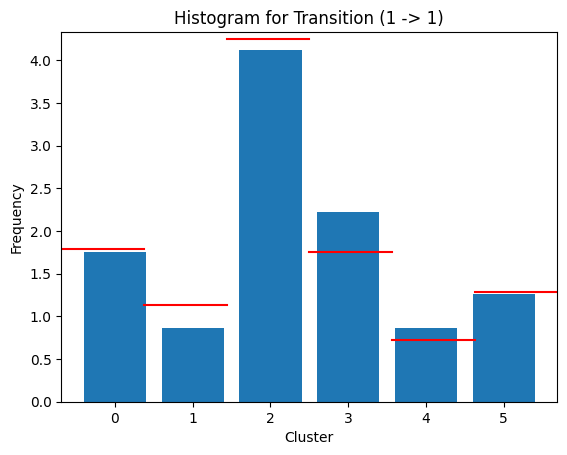

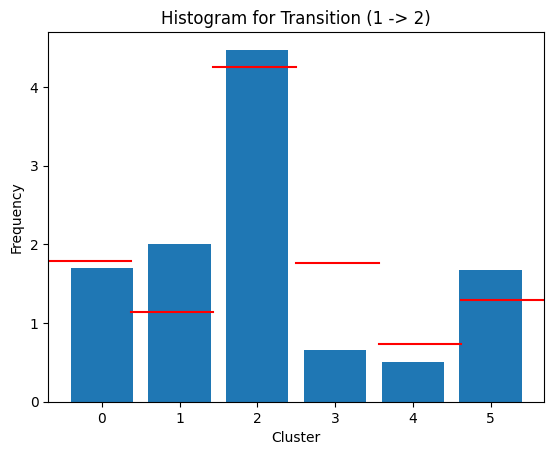

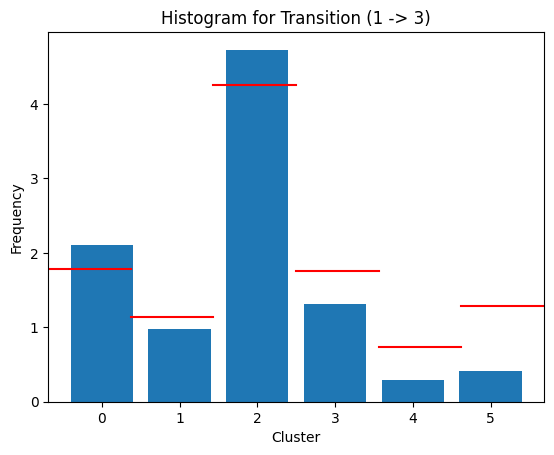

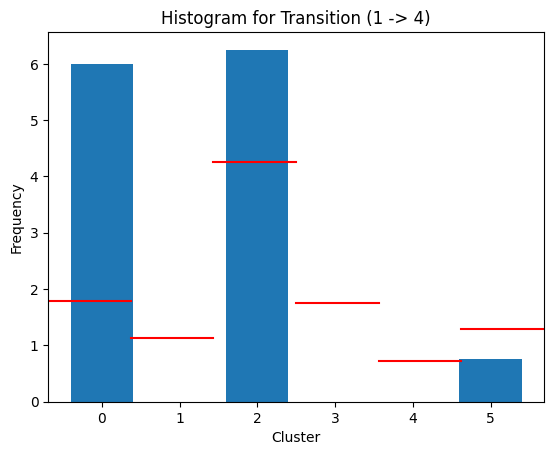

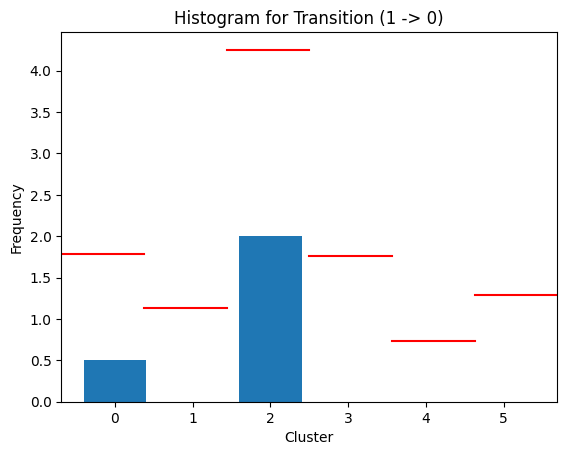

Transition (0, np.int32(1)):
  Number of Transitions: 445
Transition (0, np.int32(2)):
  Number of Transitions: 156
Transition (0, np.int32(3)):
  Number of Transitions: 48
Transition (0, np.int32(4)):
  Number of Transitions: 4
Transition (0, np.int32(0)):
  Number of Transitions: 4


In [222]:
# Filter trajectories with startingbiocluster 0
filtered_trajectories = trajectories[trajectories['startingbiocluster'] == 1]

total_avg_cluster_distribution = filtered_trajectories['ClusterDistribution'].apply(pd.Series).mean().tolist()

# Initialize a dictionary to store the results
results = {}


for ending_cluster in filtered_trajectories['endingbiocluster'].unique():
    cluster_trajectories = filtered_trajectories[filtered_trajectories['endingbiocluster'] == ending_cluster]
    avg_cluster_distribution = cluster_trajectories['ClusterDistribution'].apply(pd.Series).mean().tolist()
    num_transitions = len(cluster_trajectories)
    # Store the results
    results[(0, ending_cluster)] = {
        'average_cluster_distribution': avg_cluster_distribution,
        'num_transitions': num_transitions
    }
    plt.figure()
    plt.bar(range(len(avg_cluster_distribution)), avg_cluster_distribution)
    plt.title(f'Histogram for Transition (1 -> {ending_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.xticks(range(len(avg_cluster_distribution)))
    # plot multiple horizontal lines where the average cluster distribution is located at each bar
    for i, avg in enumerate(total_avg_cluster_distribution):
        plt.axhline(y=avg, xmin=i/len(avg_cluster_distribution), xmax=(i+1)/len(avg_cluster_distribution), color='r')
    plt.show()

# Display the results
for transition, data in results.items():
    print(f"Transition {transition}:")
    print(f"  Number of Transitions: {data['num_transitions']}")

In [223]:
trajectories.to_pickle('../data_processed/trajectories_m10.pkl')